# Assignment 2

## Short disclaimer

Hello,

This Jupyter Notebook is organised as follows:
- Formalia
- The library imports cell
- Each remaining part is structured as follows:
    - Description of the task
    - The code presenting the task solution + comments
    - Plots + comments
- Some MD cells may feature references to mathematical formulas or to additional explanations we provided

# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2021/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday October the 31st, 2021 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/


(If you haven't set up an account on peergrade yet, go to www.peergrade.io/join and type in the class code: ***DPZEV6***.)

## Overview

This year's Assignment 2 is all about analyzing the network of rappers.

Note that this time I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaningfully answer. 

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----

# Imports

In [1]:
import re
import os
import requests
import powerlaw
import nltk
import random

import networkx as nx
import numpy as np
import pandas as pd

from fa2 import ForceAtlas2
from wordcloud import WordCloud
from tqdm import tqdm
from matplotlib import pyplot as plt
from statistics import median, mean, mode
from scipy.stats import pearsonr, spearmanr
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.corpus.reader import PlaintextCorpusReader

# Part 0: Building the network 

## Task

To create our network, we downloaded the rapper Wiki pages from each coast (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions.

> Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.
> Show the regular expressions you have built and explain in details how they work.

## Solution

In [66]:
def create_directed_graph(rappers_dict):

    G = nx.DiGraph()
    
    baseurl = "https://en.wikipedia.org/w/api.php?"
    params = {
        "action":"query",
        "prop":"revisions",
        "rvprop":"content",
        "format":"json",
        "titles":"",
    }
     
    rappers_list = list(rappers_dict.keys())
    for rapper in tqdm(rappers_list):
        G.add_node(rapper, coast=rappers_dict[rapper])
            
        ### Wikipedia rapper page request ###
        
        rapper_title = rapper.replace(' ','_')
        params["titles"] = rapper_title
        data = requests.get(baseurl, params=params)
        wikijson = data.json()
        page_id = list(wikijson['query']['pages'].keys())[0]
        wikitext = wikijson['query']['pages'][page_id]['revisions'][0]['*']
        content = [word for word in wikitext.split(' ')]
        
        ### Update the node ###
        
        G.nodes[rapper]['length_of_content'] = len(content)
    
        ### Find the links to the other rappers ###
        
        links = re.findall(r'\[\[(.*?)\]\]', wikitext)
        links_to_add = []
        links_to_remove = []
        for str_ in links:
            if '|' in str_:
                links_to_add += str_.split('|')
                links_to_remove.append(str_)
        links = [link for link in links if not link in links_to_remove]
        links += links_to_add
        related_rappers = [str_ for str_ in links if str_ in rappers_list] # avoid self-loops
    
        ### Add edges based on the links to the other rappers ###
        for str_ in related_rappers:
            G.add_edge(rapper, str_)
    
    ### Remove nodes with no in- or out-degree ###
    
    l = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) == 0]
    for node in l:
        G.remove_node(node)

    return G

> Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.

We extracted the Wikipedia hyperlinks following these steps:
1. Used a regular expression to find all the expressions that match the pattern: `[[text]]`, saved them in the `links` list;
2. Looked for results matching this form: `[[text|other_text]]`, and added them in a separate list: `links_to_remove`;
    - In such situations, we split the hyperlink by the '|' character and saved the resulting strings in a separate list;
3. Removed all the strings in the `links_to_remove` from `links`;
4. Added the resultings strings from the 2nd step to the `links` list;
6. Finally, we only kept the east- or west-coast rappers from all the links.

> Show the regular expressions you have built and explain in details how they work.

The used regex expression is: `'\[\[(.*?)\]\]'`:
* `\[` and `\]` match the characters `[` and `]`, respectively;
* `.*` matches any character except the newlines (`\n`) zero or more times;
* `?` makes the `.*` non-greedy, meaning that it will match as few characters as possible, still allowing the rest of the regex (the square brakets) to match;
    * using `?` and not `+` (greedy search) allows us to capture the text between both pairs of brackets, and not just the one between the outer pair

In [3]:
df_rappers = pd.read_csv('../week6/Rappers.csv')
df_rappers.head()

,WikipediaPageName,Coast
0,6ix9ine,East
1,9th Prince,East
2,22Gz,East
3,38 Spesh,East
4,The 45 King,East


In [4]:
rappers_dict = dict(zip(list(df_rappers['WikipediaPageName']), list(df_rappers['Coast'])))

* `zip` function interlashes 2 lists, turning them into a list of tuples `(elem from list 1, elem from list 2)`;
* `dict` function converts the tuples list into a dictionary, where the key is the first element of the tuple, and the value is the second one

In [5]:
G = create_directed_graph(rappers_dict)
# nx.write_gml(G, 'directed_graph.gml')

100%|██████████| 798/798 [06:36<00:00,  2.01it/s]


In [6]:
# G = nx.read_gml('directed_graph.gml')

In [7]:
### Extracting the largest connected component ###

largest_comp = max(nx.weakly_connected_components(G), key=len)
G = G.subgraph(largest_comp)
G = nx.DiGraph(G)

# Part 1: Network visualization and basic stats

## Tasks

Visualize your network of rappers (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you have already generated the network and extracted the largest weakly connected component (the "largest weakly connected component" of a directed network is the subgraph consisting of the nodes that would constitute the largest connected component if the network were undirected) . The visualization and statistics should be done for the largest weakly connected component only.

_Exercise 1a_: Stats (see lecture 4 and 5 for more hints)

> * What is the number of nodes in the network? 
> * What is the number of links?
> * Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?
> * Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)? 
> * Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?
> * Plot the in- and out-degree distributions for the whole network. 
>   * Use axes that make sense for visualizing this particular distribution.
>   * What do you observe? 
>   * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?
> * Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?
> * Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.

_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (directed) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
>   * Whatever else you feel like that would make the visualization nicer.
> * Describe the structure you observe. What useful information can you decipher from this?

## Solutions

### _Exercise 1a_

> What is the number of nodes in the network? 

> What is the number of links?

In [8]:
print('Number of nodes: {}'.format(len(G.nodes())))
print('Number of edges: {}'.format(len(G.edges())))

Number of nodes: 730
Number of edges: 5915


> Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

In [9]:
in_degree_dict = {node: G.in_degree(node) for node in G.nodes()}
out_degree_dict = {node: G.out_degree(node) for node in G.nodes()}

In [10]:
top_in = max(in_degree_dict, key=in_degree_dict.get)
top_out = max(out_degree_dict, key=out_degree_dict.get)
print(f'Top connected rapper (in-degree-wise): {top_in}, with degree = {in_degree_dict[top_in]}')
print(f'Top connected rapper (out-degree-wise): {top_out}, with degree = {out_degree_dict[top_out]}')

Top connected rapper (in-degree-wise): Snoop Dogg, with degree = 125
Top connected rapper (out-degree-wise): Drag-On, with degree = 52


* **Snoop Dogg** is one of the expected rappers to have the **highest in-degree (152)**. He is one of the most famous rappers artists, and in all his years of activity, many rappers collaborated with him because of his fame, thus the high in-degree.

* On the other hand, we didn't expect **Drag-On** to have the **highest out-degree (52)**. But we checked his Wikipedia page, and it has a dedicated section named _Guest Apparences_, featuring a lot of artists from the two Coasts (and not only) that he collaborated with. This explains the high out-degree.

> Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)? 
> Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?

In [11]:
tmp = sorted(in_degree_dict.items(), key = lambda x: x[1], reverse = True)
in_degree_east = [item for item in tmp if rappers_dict[item[0]] == 'East']
in_degree_west = [item for item in tmp if rappers_dict[item[0]] == 'West']

tmp = sorted(out_degree_dict.items(), key = lambda x: x[1], reverse = True)
out_degree_east = [item for item in tmp if rappers_dict[item[0]] == 'East']
out_degree_west = [item for item in tmp if rappers_dict[item[0]] == 'West']

del tmp

In [12]:
print('The top 5 most connected east-rappers (in-degree-wise) are:')
print('\n')
for elem in in_degree_east[:5]:
    print(elem[0].ljust(30), 'in-degree value:', elem[1])
    
print('\n', 50*'=', '\n')
    
print('The top 5 most connected east-rappers (out-degree-wise) are:')
print('\n')
for elem in out_degree_east[:5]:
    print(elem[0].ljust(30), 'out-degree value:', elem[1])

The top 5 most connected east-rappers (in-degree-wise) are:


Jay-Z                          in-degree value: 115
Nas                            in-degree value: 104
50 Cent                        in-degree value: 92
Busta Rhymes                   in-degree value: 83
The Notorious B.I.G.           in-degree value: 63


The top 5 most connected east-rappers (out-degree-wise) are:


Drag-On                        out-degree value: 52
Black Thought                  out-degree value: 42
MC Lyte                        out-degree value: 35
Jahlil Beats                   out-degree value: 35
DJ Premier                     out-degree value: 34


In [13]:
print('The top 5 most connected west-rappers (in-degree-wise) are:')
print('\n')
for elem in in_degree_west[:5]:
    print(elem[0].ljust(30), 'in-degree value:', elem[1])
    
print('\n', 50*'=', '\n')
    
print('The top 5 most connected west-rappers (out-degree-wise) are:')
print('\n')
for elem in out_degree_west[:5]:
    print(elem[0].ljust(30), 'out-degree value:', elem[1])

The top 5 most connected west-rappers (in-degree-wise) are:


Snoop Dogg                     in-degree value: 125
Dr. Dre                        in-degree value: 81
Kendrick Lamar                 in-degree value: 75
Tupac Shakur                   in-degree value: 70
E-40                           in-degree value: 63


The top 5 most connected west-rappers (out-degree-wise) are:


Kendrick Lamar                 out-degree value: 39
Dr. Dre                        out-degree value: 38
DJ Dahi                        out-degree value: 38
Kurupt                         out-degree value: 36
The Game (rapper)              out-degree value: 36


> Plot the in- and out-degree distributions for the whole network. 
>   * Use axes that make sense for visualizing this particular distribution.
>   * What do you observe? 
>   * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?

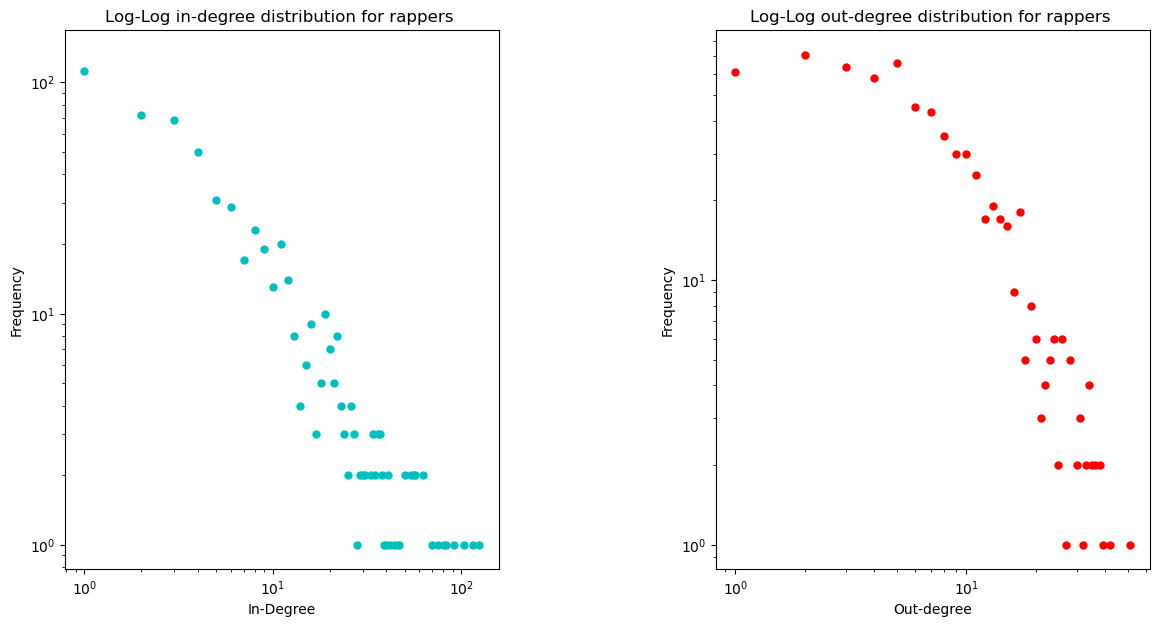

In [78]:
in_degrees = list(in_degree_dict.values())
out_degrees = list(out_degree_dict.values())

bins = [i for i in range(min(in_degrees), max(in_degrees) + 1)]
degrees_hist, degrees_bin = np.histogram(in_degrees, bins=bins)

plt.figure(figsize=(14, 7)) 
plt.subplot(1, 2, 1)
plt.loglog(degrees_bin[:-1], degrees_hist, 'co', markersize=5)
plt.xlabel('In-Degree')
plt.ylabel('Frequency')
plt.title('Log-Log in-degree distribution for rappers ')

bins = [i for i in range(min(out_degrees), max(out_degrees) + 1)]
degrees_hist, degrees_bin = np.histogram(out_degrees, bins=bins)

plt.subplot(1, 2, 2)
plt.loglog(degrees_bin[:-1], degrees_hist, 'ro', markersize=5)
plt.subplots_adjust(wspace=0.5)
plt.xlabel('Out-degree')
plt.ylabel('Frequency')
plt.title('Log-Log out-degree distribution for rappers ')
plt.show()

- We considered the log-log plot for illustrating that the in- and out-degree distributions do not respect a Poisson distribution, hence the rappers graph is not considered a random network, but rather a **real network**;
- Another important aspect highlighted in these plots is the existence of **hubs** (nodes with high in- or out-degree), seen for the high degree values of the distributions. These hubs only exist in real networks, and it states that high-degree nodes can coexist with small-degree nodes (this aspect will be clearily visible when plotting the graph).
- The difference between the two distributions may result from these causes:
    1. Each edge has a direction, and in most cases, going from one node to another, and not the way around. Thus the way a directed graph is built drives to this difference;
    2. In a real world scenario, the relationships between nodes is often asymetric. In our case, a popular rapper might have a high in-degree, since many rappers want to collaborate with him. But those rappers won't collaborate with many other ones, thus the low out-degree.

> Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?

In [53]:
in_degree_exponent = powerlaw.Fit(in_degrees, verbose = False).alpha
out_degree_exponent = powerlaw.Fit(out_degrees, verbose = False).alpha

print('In degree exponent: %.2f' % in_degree_exponent)
print('Out degree exponent: %.2f' % out_degree_exponent)

In degree exponent: 2.84
Out degree exponent: 3.72


C:\ProgramData\anaconda3\Lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


* The in- and out-degree distributions follow a power-law distribution, with $\gamma_{in} = 2.84, \gamma_{out} = 3.72$;
* The in-degree exponent has a value $\gamma_{in} \in [2,3]$, which states that the netowrk has the **ultra-small world** property: $\langle d \rangle \sim \ln(\ln(N))$;
    * An explanation would be that the hubs link a large number of low-degree nodes, creating short paths between them;
* The out-degree exponent has a value $\gamma_{out} > 3$, stating that the network has the **small-world** property: $\langle d \rangle \sim \ln(N)$;
    * In contrast to the in-degree scenario, since the number of hubs is lower regarding the out-degree, the average shortest path will be longer as well.
    
[Social Networks, Chapter 4, Sections 4.6, 4.7](http://networksciencebook.com/chapter/4#ultra-small)

> Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.

In [16]:
total_degrees = [G.degree(node) for node in G.nodes()]

p = 0.02
N = 730
Average degree <k> = 16.37




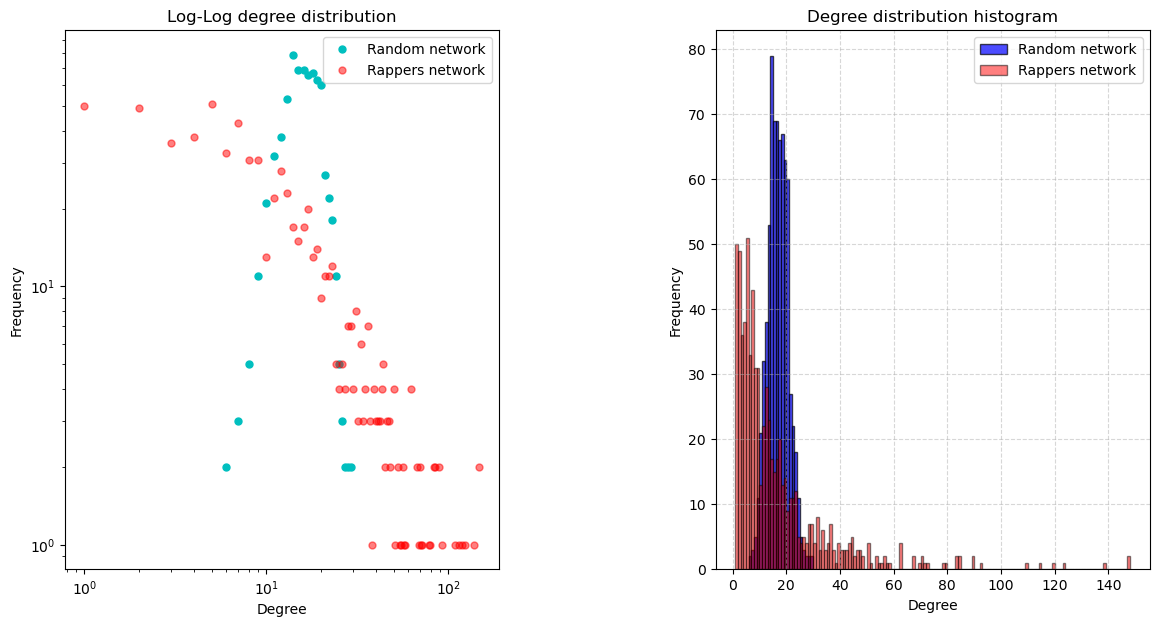

In [77]:
avg_degree = mean([G.degree(node) for node in G.nodes()])
N = len(G.nodes())
p = avg_degree/N

print('p = %.2f' % p)
print('N = %d' % N)

RN = nx.erdos_renyi_graph(N, p)

degrees = [RN.degree(node) for node in RN.nodes()]
print('Average degree <k> = %.2f' % mean(degrees))
print('\n')

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)

bins = [i for i in range(min(degrees), max(degrees) + 1)]
degrees_hist, degrees_bin = np.histogram(degrees, bins=bins)
plt.loglog(degrees_bin[:-1], degrees_hist, 'co', markersize=5, label = 'Random network')

bins = [i for i in range(min(total_degrees), max(total_degrees) + 1)]
degrees_hist, degrees_bin = np.histogram(total_degrees, bins=bins)
plt.loglog(degrees_bin[:-1], degrees_hist, 'ro', alpha = 0.5, markersize=5, label = 'Rappers network')

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Log-Log degree distribution')
plt.legend()

plt.subplot(1,2,2)
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 1), alpha=0.7, width=1.0, 
         color='b', edgecolor='black', label = 'Random network')
plt.hist(total_degrees, bins=range(min(total_degrees), max(total_degrees) + 1), alpha=0.5, width=1.0, 
         color='r', edgecolor='black', label = 'Rappers network')

plt.subplots_adjust(wspace=0.5)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree distribution histogram')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

* The Erdos-Renyi random network has the probability of connectivity $p = 0.02$ and average degree $\langle k \rangle = 16.48$;
* The degree distribution of the random network follow a Poisson distribution
* In this type of network, hubs are missing, and most of the nodes tend to have the degree close to the average degree $\langle k \rangle$.

### _Exercise 1b_

> Create a nice visualization of the total (directed) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
>   * Whatever else you feel like that would make the visualization nicer.

In [18]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    edgeWeightInfluence = 0.0,
    
    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    
    # Tuning
    scalingRatio=1.0,
    strongGravityMode=False,
    gravity = 1.0,
    
    # Log
    verbose=True)

In [19]:
H = G.copy()

### Setting nodes color ###
node_colors = ['deepskyblue' if rappers_dict[node] == 'East' else 'orange' for node in list(H.nodes())]

### Setting nodes sizes according to their degree ###
node_size = [3 * H.degree(node) for node in G.nodes()]

### Setting edge weights (only for graph plotting) ###
edges_attr = {}
for edge in H.edges():
    weight = 1 if rappers_dict[edge[0]] == rappers_dict[edge[1]] else 2
    edges_attr[edge] = {'weight': weight}
nx.set_edge_attributes(H, edges_attr)

### Setting edges colors ###
edge_colors = []
for edge in H.edges():
    if rappers_dict[edge[0]] == rappers_dict[edge[1]] == 'East':
        edge_colors.append('blue')
    elif rappers_dict[edge[0]] == rappers_dict[edge[1]] == 'West':
        edge_colors.append('darkorange') 
    else:
        edge_colors.append('gold') 
        
# positions = forceatlas2.forceatlas2_networkx_layout(H, pos = nx.circular_layout(H), iterations=1000)

* We made a copy of the original graph which we only used for plotting;
* For a nice graph plotting, we had to set the edge weights to higher values if the nodes belonged to different coasts;
* We tried to use the `ForceAtlas2` algorithm for the nodes positions, but with no success for the directed graph, so we finally used the Kamada-Kawai algorithm from the `networkx` library.

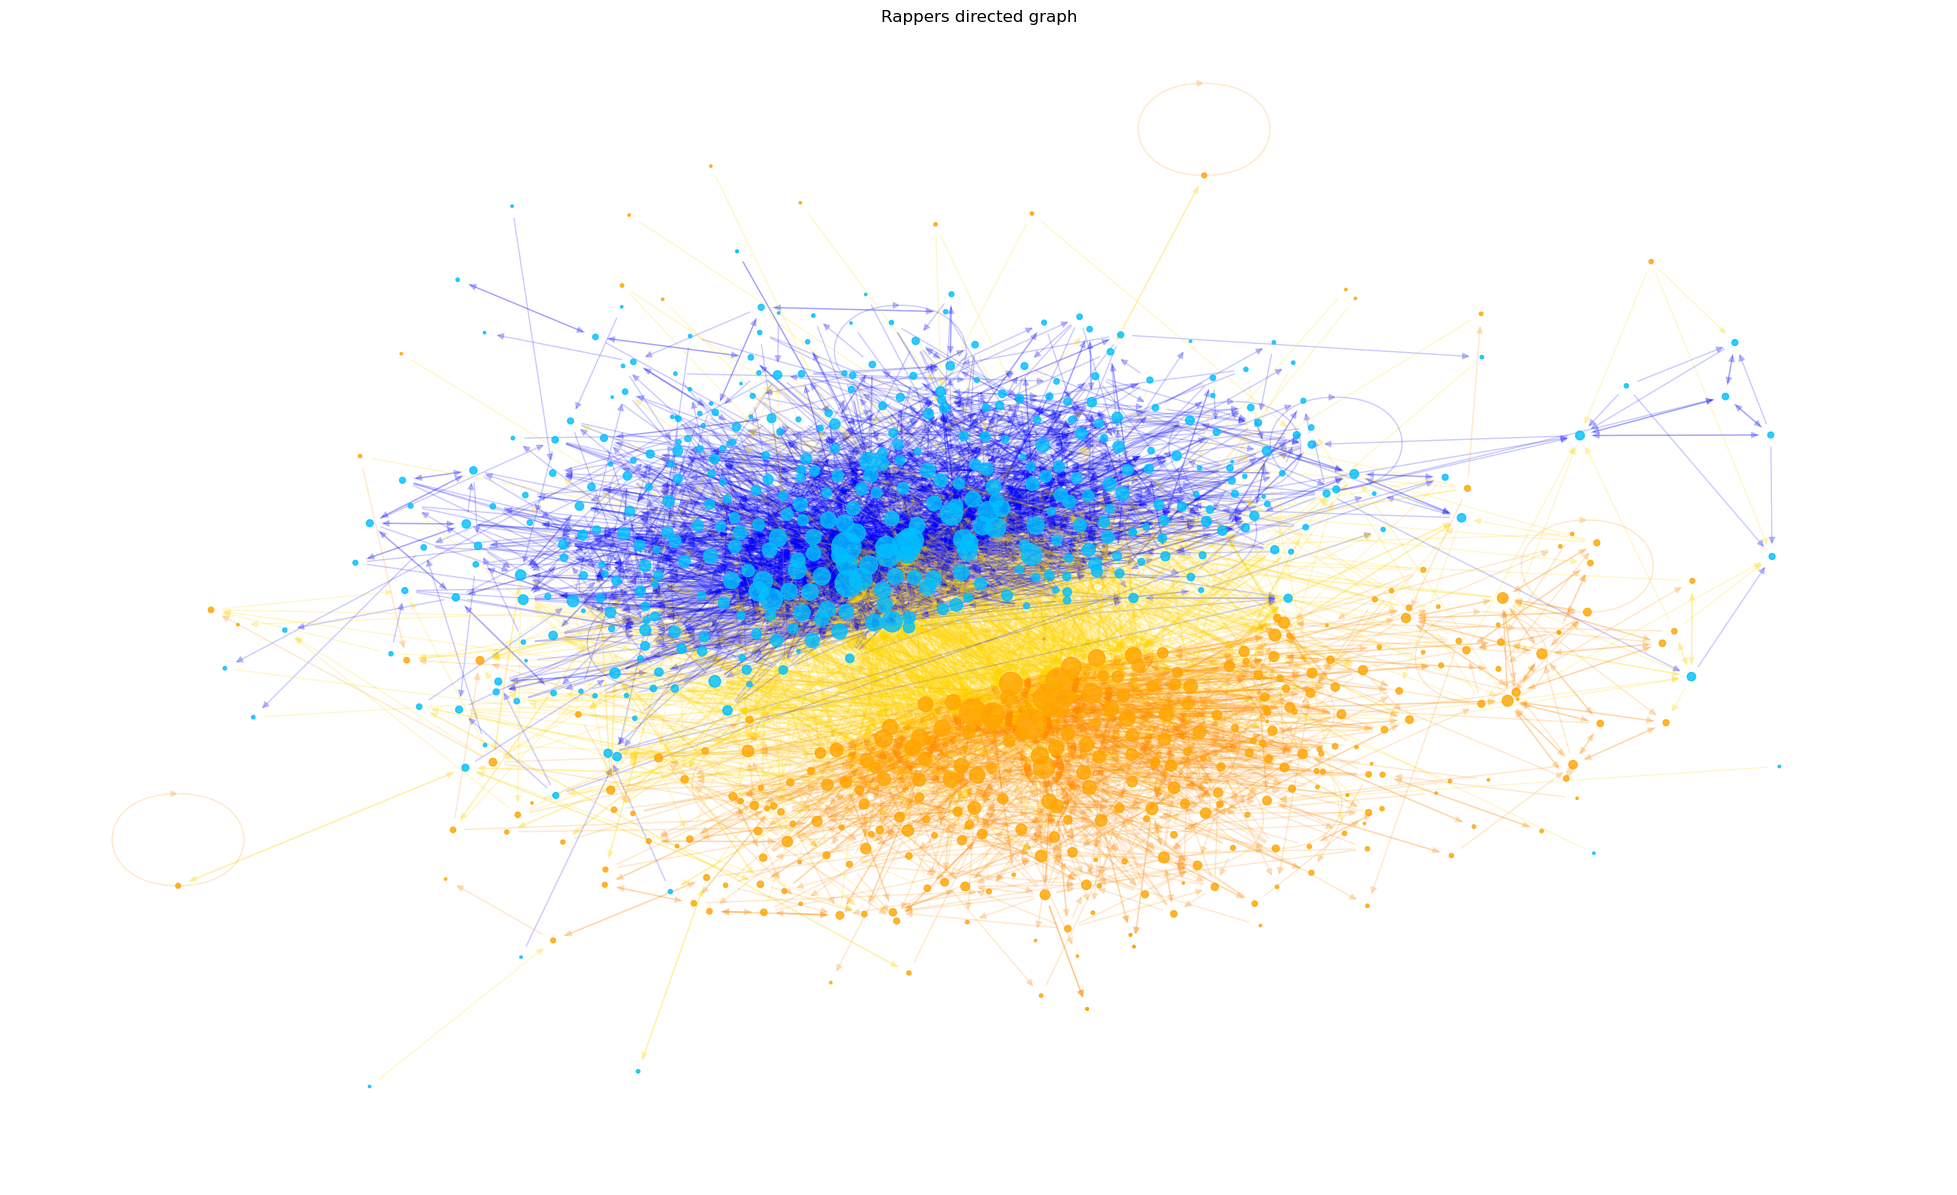

In [20]:
positions = nx.kamada_kawai_layout(H)
plt.figure(figsize=(25, 15))
nx.draw_networkx_nodes(H, positions, node_color = node_colors, node_size = node_size, alpha=0.8)
nx.draw_networkx_edges(H, positions, edge_color = edge_colors, alpha=0.2)
plt.title('Rappers directed graph')
plt.axis('off')
# plt.legend()
plt.show()

> Describe the structure you observe. What useful information can you decipher from this?

* The nodes are divided in two communinites: East Coast (blue nodes) and West coast (orange nodes);
* The hubs are strongly visible and placed in the center of each community due to their high degree centrality;
* Some nodes have more connections to nodes from the other coast, while some only have connections to the other coast, meaning that they might not belong to their coast community (more about this in Part 3).

# Part 2: Word-clouds

## Task

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from rappers' Wikipedia pages.

Here's what you need to do:
> * Create a word-cloud for each coast according to the novel TF-TR method. Feel free to make it as fancy as you like. Explain your process and comment on your results.
> * For each coast, what are the 5 words with the highest TR scores? Comment on your result.

## Solution

* Download the texts from rappers' Wikipedia pages

In [21]:
def create_coast_texts():
    east_coast_text = ''
    west_coast_text = ''
    
    for name in tqdm(df_rappers['WikipediaPageName']):
        baseurl = "https://en.wikipedia.org/w/api.php?"
        params = {
            "action":"query",
            "prop":"extracts",
            "exlimit":"1",
            "explaintext": "1",
            "format":"json",
            "titles":name,
        }
    
        data = requests.get(baseurl, params=params)
        wikijson = data.json()
        page_id = list(wikijson['query']['pages'].keys())[0]
        plain_text = wikijson['query']['pages'][page_id]['extract']
        if rappers_dict[name] == 'East':
            east_coast_text += plain_text + ' '
        else:
            west_coast_text += plain_text + ' '
    return east_coast_text, west_coast_text

In [22]:
east_coast_text, west_coast_text = create_coast_texts()

# corpus_east = PlaintextCorpusReader('../week7/eastcoasttexts/', ".*\.txt")
# corpus_west = PlaintextCorpusReader('../week7/westcoasttexts/', ".*\.txt")

# text_east = nltk.text.Text(corpus_east.words())
# text_west = nltk.text.Text(corpus_west.words())

# east_coast_text = ' '.join(text_east)
# west_coast_text = ' '.join(text_west)

100%|██████████| 801/801 [06:00<00:00,  2.22it/s]


* Define a list of stop-words:
    * We combined the NLTK stopwords list with a list containing very common words for both coasts:

In [23]:
stop_words = list(set(stopwords.words('english')))
common_words = ['album', 'albums', 'release', 'released', 'song', 'songs', 'rapper', 'rappers', 'singer', 'singers', 
                'artist', 'artists', 'single', 'singles','record', 'records','new', 'producer', 'hip', 'hop', 'first', 
                'also', 'featured', 'featuring', 'music', 'year', 'mixtape', 'rap']
stop_words += common_words
stop_words = set(stop_words)

* Tokenize the text using a regex-based tokenizer to eliminate all punctuation:

In [24]:
tokenizer = RegexpTokenizer(r'\w+')
tokens_east = tokenizer.tokenize(east_coast_text)
tokens_west = tokenizer.tokenize(west_coast_text)

* Select all lowercased tokens that are not stop-words:

In [25]:
tokens_east = [w.lower() for w in tokens_east if not w.lower() in stop_words]
tokens_west = [w.lower() for w in tokens_west if not w.lower() in stop_words] 

* Create a TF dictionary for each coast:

In [26]:
tf_east = FreqDist(tokens_east)
tf_west = FreqDist(tokens_west)

* Create a TF-TR dictionary for each coast. The $c$ parameter is used to avoid division by 0, and it controls the weight value for each word in our corpus. Higher values of $c$ would result in high weights for common words, so a relatively small value $c = 10$ has been used.

In [27]:
c = 10
tr_east = {}
tr_west = {}

for key in tf_east.keys():
    tr_east[key] = tf_east[key]/(tf_west[key] + c) if key in tf_west else tf_east[key]/c
    
for key in tf_west.keys():
    tr_west[key] = tf_west[key]/(tf_east[key] + c) if key in tf_east else tf_west[key]/c

* Create a single string for each coast through combining all the words together, repeating each word according to its rounded score value:

In [28]:
west_text = ''
for key in tf_west.keys():
    west_text += (key+' ') * round(tf_west[key]*tr_west[key])

east_text = ''
for key in tf_east.keys():
    east_text += (key+' ') * round(tf_east[key]*tr_east[key])

* Plot the WordCloud images

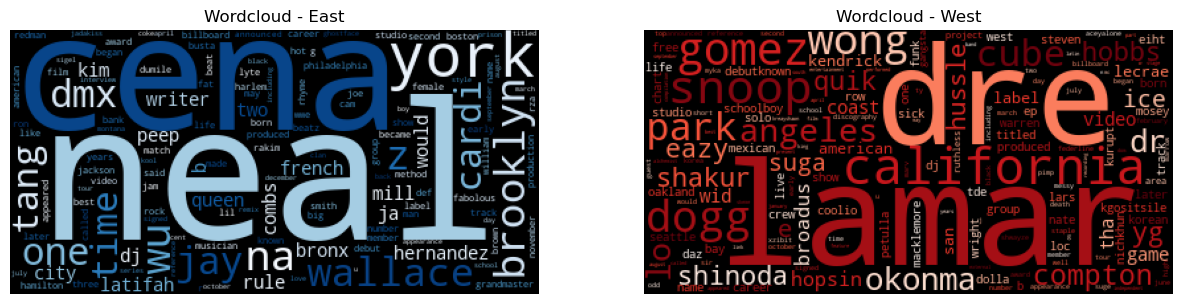

In [29]:
wordcloud_east = WordCloud(colormap = 'Blues', collocations=False, stopwords = stop_words).generate_from_text(east_text)
wordcloud_west = WordCloud(colormap = 'Reds', collocations=False, stopwords = stop_words).generate_from_text(west_text)

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_east)
plt.title('Wordcloud - East')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wordcloud_west)
plt.title('Wordcloud - West')
plt.axis('off')
plt.show()

**Comments**
* The $c$ parameter was set so that the important words from each coast should get a higher weight value;
* Each wordcloud features important names in the rap world specific to each coast:
    * For example, the East Coast features words like _hernandez_ (rapper 6ix9ine), _wallace_ (Notorius B.I.G), _dmx_, _new york_, _brooklyn_ etc. which are not met or not common at all for the West Coast, where we meet characteristic examples like _dre_, _lamar_, _snoop_, _california_ etc. 
* The unusual aspect is that _neal_ and _cena_ (Shaquill O'Neal, John Cena) have the highest TF-TR value. Though these 2 are not known for their rap career, compared to other names featured in the wordcloud, both of them are renowned media personalities and have collaborated with many East Coast rappers, hence the high TR value.

> For each coast, what are the 5 words with the highest TR scores? Comment on your result.

In [30]:
top_east = sorted(tr_east.items(), key = lambda x: x[1], reverse = True)
top_west = sorted(tr_west.items(), key = lambda x: x[1], reverse = True)

In [31]:
print('The 5 words with the highest TR scores:')
print('East Coast:')
print('Word'.ljust(15), 'Weight')
print(40 * '-')
for elem in top_east[:5]:
    print(elem[0].ljust(15), round(elem[1], 2))
    
print('\n', 40*'*', '\n')
    
print('West Coast')
print('Word'.ljust(15), 'Weight')
print(40*'-')
for elem in top_west[:5]:
    print(elem[0].ljust(15), round(elem[1], 2))

The 5 words with the highest TR scores:
East Coast:
Word            Weight
----------------------------------------
neal            24.41
cena            20.86
hernandez       14.27
cardi           13.23
wallace         13.06

 **************************************** 

West Coast
Word            Weight
----------------------------------------
wong            12.82
gomez           12.46
okonma          10.6
hobbs           9.6
shinoda         9.27


* Each set of top 5 words feature unique words to each coast:
    * East Coast: neal (Shaquill O'Neal), cena (John Cena), hernandez (6ix9ine), cardi (Cardi B), wallace (Notorious B.I.G);
    * West Coast: wong (Fresh Kid Ice), gomez (Taboo, member of Black Eyed Peas), Okonma (Tyler, the Creator), hobbs (Mr. Mixx), shinoda (Mike Shinoda, member of Linkin Park)
* The TR values for the East Coast words are higher than the West Coast ones, this is caused by the inequality of the texts sizes, the former coast having a bigger number of tokens than the latter.

# Part 3: Communities

## Task

Find communities and their modularity (from lecture 7).

Here's what you need to do:
> * In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it. 
> * Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?
> * Comment on your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot and/or print the distribution of community sizes (whichever makes most sense). Comment on your result.
> * Now, partition your rappers into two communities based on which coast they represent.
>   * What is the modularity of this partition? Comment on the result.

## Solution

> In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it. 

* Modularity refers to the possibility of a graph network to be divided into separate and well-defined subgraphs called communities;
* The intuition behind modularity is to compare the actual wiring diagram within the network to what we would expect in a random network: $M_c = \frac{1}{2L}\sum_{i,j \in C_c}(A_{i,j} - p_{i,j})$, where
    * $L$ is the number of edges
    * $C_c$ is a presumed community within the network
    * $A_{i,j}$ is the actual number of edges between nodes _i_ and _j_
    * $p_{i,j} = \frac{k_i k_j}{2L}$ is the expected number of edges between node _i_ and _j_ in the randomized original network
* Judging by the equation, it can be concluded that:
    * For negative modularity values, the graph cannot be divided into communities; 
    * A zero modularity implies that the graph can be seen as a single community;
    * As the modulaity gets higher, the graph can be split into more well-defined communities.
    
[Social Networks, Chapter 9, Section 9.4](http://networksciencebook.com/chapter/9#modularity)

> Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?

This part of the task will be carried out using the Louvain Community Detection Algorithm. The official documentation states that self-loops should be removed, since they will be treated as single communities.

In [32]:
self_loops = [edge for edge in G.edges() if edge[0] == edge[1]]
print('# of self-loops: {}'.format(len(self_loops)))
for edge in self_loops:
    G.remove_edge(*edge)

# of self-loops: 29


The algorithm works in 2 steps:

* On the first step it assigns every node to be in its own community and then for each node it tries to find the maximum positive modularity gain by moving each node to all of its neighbor communities. If no positive gain is achieved the node remains in its original community.
    * The modularity gain obtained by moving an isolated node into a community $C$ is calculated by the formula (for a directed graph): $\Delta Q = \frac{k_{i,in}}{2m}-\gamma\frac{k_i^{out}\sum^{in}_{tot}k_i^{in}\sum^{out}_{tot}}{2m^2}$, where 
        * $k_{i, in}$ is the sum of the weights of the links from $i$ to nodes in $C$, 
        * $m$ is the number of edges in the network,
        * $k_i^{in}, k_i^{out}$ are the inner and outer weighted degrees of node $i$, 
        * $\sum^{in}_{tot},\sum^{out}_{tot}$ are the sum of in-going and out-going links incident to nodes in $C$,
        * $\gamma$ is the resolution parameter.
    * The first phase continues until no individual move can improve the modularity.
* The second phase consists in building a new network whose nodes are now the communities found in the first phase. To do so, the weights of the links between the new nodes are given by the sum of the weight of the links between nodes in the corresponding two communities. Once this phase is complete it is possible to reapply the first phase creating bigger communities with increased modularity.

The above two phases are executed until no modularity gain is achieved, or its value is smaller than a threshold value. By default, this threshold is set to $\epsilon = 10^{-7}$

[Louvian Communities](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html#networkx.algorithms.community.louvain.louvain_communities)

* We determined the number of communities by finding the optimal resolution value for which the modularity is maximized:

In [33]:
resolution = np.arange(0.5, 3, 0.1)
best_modularity = -100
optimal_resolution = 0
for res in resolution:
    communities = nx.community.louvain_communities(G, resolution = res, seed = 42)
    modularity = nx.community.modularity(G, communities)
    if modularity > best_modularity:
        best_modularity = modularity
        optimal_resolution = res

> Comment on your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot and/or print the distribution of community sizes (whichever makes most sense). Comment on your result.

In [34]:
print(f'Optimal resolution: {optimal_resolution:.2f}')
communities = nx.community.louvain_communities(G, resolution = optimal_resolution, seed = 42)
print(f'Number of communities: {len(communities)}')
modularity = nx.community.modularity(G, communities)
print('Partition modularity: {}'.format(round(modularity, 2)))

Optimal resolution: 1.00
Number of communities: 9
Partition modularity: 0.43


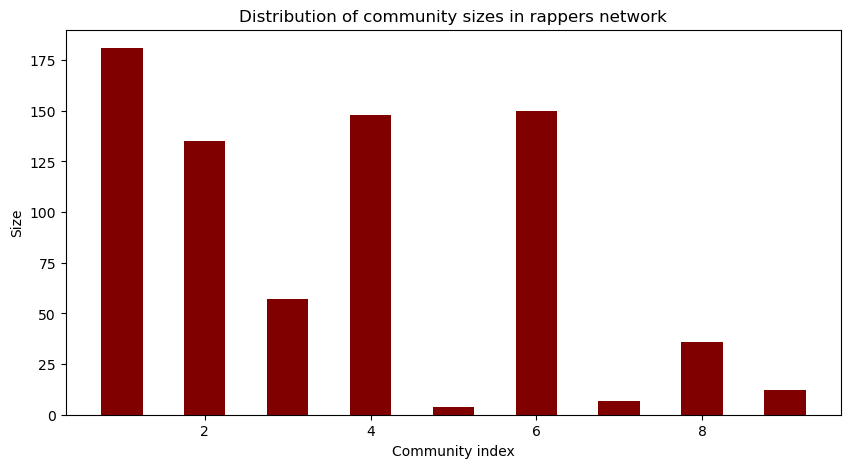

In [35]:
community_sizes = [len(community) for community in communities]
values = list(range(1, len(community_sizes) + 1))
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(values, community_sizes, color ='maroon', width = 0.5)
 
plt.xlabel("Community index")
plt.ylabel("Size")
plt.title("Distribution of community sizes in rappers network")
plt.show()

* Having the optimal resolution parameter set to $\gamma = 1$, the Louvian algorithm determined the **9 communities** in the rappers network, with sizes varying from 4 nodes to 181 nodes. 
* The partition modularity is $M_c = 0.43$;
* The bigger communities are centered around the hubs of the network;
* The smaller communities are determined by the low-degree nodes, with fewer connections;
* Rappers from the same coast tend to form the majority of the nodes in a community;
* To support these comments, we defined a Pandas dataframe: for each community, we determined its size, how many rappers are from the each coast, the minimum and maximum degree of nodes:

In [36]:
community_df = pd.DataFrame(columns = ['Community size', 'East rappers', 'West rappers', 'Min degree', 'Max degree'])
def get_community_metadata(community):
    coasts = [rappers_dict[rapper] for rapper in community]
    east_coasts = coasts.count('East')
    west_coasts = coasts.count('West')
    degrees = [G.degree(rapper) for rapper in community]
    min_degree = min(degrees)
    max_degree = max(degrees)
    return 

for i, community in enumerate(communities):
    coasts = [rappers_dict[rapper] for rapper in community]
    e_rappers = coasts.count('East')
    w_rappers = coasts.count('West')
    degrees = [G.degree(rapper) for rapper in community]
    min_degree = min(degrees)
    max_degree = max(degrees)
    community_df.loc[(len(community_df))] = [len(community), e_rappers, w_rappers, min_degree, max_degree]

community_df = community_df.sort_values(by = ['Community size'], ascending = False).reset_index().drop('index', axis = 1)
community_df.head(15)

,Community size,East rappers,West rappers,Min degree,Max degree
0,181,172,9,1,147
1,150,16,134,1,148
2,148,59,89,1,114
3,135,114,21,1,84
4,57,38,19,1,72
5,36,11,25,1,20
6,12,4,8,1,28
7,7,2,5,1,6
8,4,0,4,4,7


> Now, partition your rappers into two communities based on which coast they represent.
>   * What is the modularity of this partition? Comment on the result.

In [37]:
def coast_modularity(coast):
    nodes = [node for node in G.nodes() if rappers_dict[node] == coast]
    edges = [edge for edge in G.edges() if rappers_dict[edge[0]] == rappers_dict[edge[1]] == coast]
    Lc = len(edges)
    L = len(G.edges())
    kc = sum([G.degree(node) for node in nodes])
    M = Lc/L - (kc/(2*L))**2
    return M

In [38]:
M_east = coast_modularity('East')
M_west = coast_modularity('West')

In [39]:
print(f'Partition modularity: {round(M_east + M_west, 2)}')

Partition modularity: 0.26


* The modularity is smaller: $M_c = 0.26$ but not close to zero, suggesting that it is possible to partition this graph in two communities;
* However, this would be **suboptimal partitioning**: it can be seen in the graph representation that some east coast nodes are positioned among the west coast ones, having a stronger connectivity to them, so the communities would not be entirely made up of nodes from the same coast.

# Part 4: Sentiment of communities


## Task

Analyze the sentiment of communities (lecture 8). More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* Average the average sentiment of the nodes in each community to find a community-level sentiment.

Here's what you need to do (use the LabMT wordlist approach):
> * Calculate and store sentiment for every rapper
> * Create a histogram of all rappers' associated sentiments.
> * What are the 10 rappers with happiest and saddest pages?

Now, compute the sentiment of each coast: 
> * Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).
> * Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.
> * Does the result make sense to you? Elaborate.

## Solution

> Calculate and store sentiment for every rapper
> Create a histogram of all rappers' associated sentiments.
> What are the 10 rappers with happiest and saddest pages?

In [40]:
df_labmt = pd.DataFrame(columns = ['word', 'happiness_rank', 'happiness_average', 'happiness_standard_deviation', 
                                  'twitter_rank', 'google_rank', 'nyt_rank', 'lyrics_rank'])

f = open("../week8/Data_Set_S1.txt", "r")
for i, x in enumerate(f):
    if i < 4:
        continue
    
    df_labmt.loc[len(df_labmt)] = re.findall(r'\S+', x)
    

wordlist = dict(zip(list(df_labmt['word']), [float(item) for item in df_labmt['happiness_average']]))

In [41]:
#### "Happiest" 5 tokens ####

df_labmt.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [42]:
#### Saddest 5 tokens ####

df_labmt.tail()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
10217,murder,10218,1.48,1.0150,2762,3110,1541,1059
10218,terrorism,10219,1.48,0.9089,--,--,3192,--
10219,rape,10220,1.44,0.7866,3133,--,4115,2977
10220,suicide,10221,1.30,0.8391,2124,4707,3319,2107
10221,terrorist,10222,1.30,0.9091,3576,--,3026,--


In [43]:
def avg_sentiment_calulator(tokens, wordlist):
    if len(tokens) == 0:
        raise Exception("Empty list of tokens.")
    freq_dict = dict(FreqDist(tokens))
    valid_tokens = [token for token in tokens if token in list(wordlist.keys())]
    avg_sent = sum(freq_dict[token]*wordlist[token] for token in valid_tokens)/sum(freq_dict[token] for token in valid_tokens)
    return avg_sent

In [44]:
sentiments = {}
for dir_ in ['../week7/westcoasttexts', '../week7/eastcoasttexts/']:
    for file in os.listdir(dir_):
        if file.endswith(".txt"):
            rapper = file[:-4]
            rapper = rapper.replace('_', ' ')
            if 'K-the-I' in rapper:
                rapper = rapper.replace(' ', '?')
            file = os.path.join(os.path.abspath(dir_), file)
            with open(file, 'r', encoding="utf-8") as f:
                content = f.read()
            tokens = word_tokenize(content)
            
            ### Avoid rappers with null page sentiment ###
            if len(tokens) == 0:
                continue
            
            tokens = [token.lower() for token in tokens]
            avg_sent = avg_sentiment_calulator(tokens, wordlist)
            sentiments[rapper] = round(avg_sent, 2)

In [45]:
sentiment_scores = list(sentiments.values())
bins = np.arange(min(sentiment_scores), max(sentiment_scores) + 0.05, 0.05)

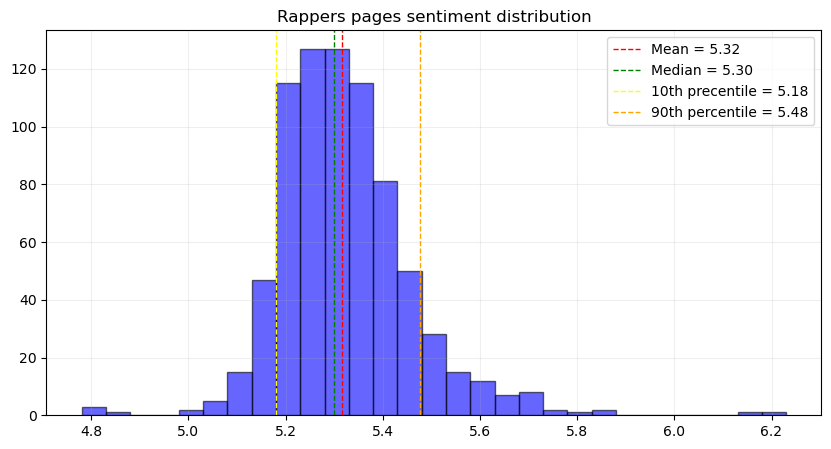

In [67]:
plt.figure(figsize=(10,5))

mean_ = mean(sentiment_scores)
median_ = median(sentiment_scores)
p_10 = np.percentile(sentiment_scores, 10)
p_90 = np.percentile(sentiment_scores, 90)
plt.axvline(mean_, color='red', linestyle='dashed', linewidth=1, label=f'Mean = {mean_:.2f}')
plt.axvline(median_, color='green', linestyle='dashed', linewidth=1, label=f'Median = {median_:.2f}')
plt.axvline(p_10, color='yellow', linestyle='dashed', linewidth=1, label=f'10th precentile = {p_10:.2f}')
plt.axvline(p_90, color='orange', linestyle='dashed', linewidth=1, label=f'90th percentile = {p_90:.2f}')
_ = plt.hist(sentiment_scores, bins=bins, alpha=0.6, color='b', edgecolor='black')
plt.title("Rappers pages sentiment distribution")
plt.legend()

plt.grid(alpha = 0.2)
plt.show()

* The rappers pages have the mean sentiment $\mu_{sentiment} = 5.32$, and the 90th percentile $p_{90} = 5.48$. Judging by these values, these pages have a rather neutral sentiment; 
* This might be true because Wikipedia are pages written in an objective language, with no tendency to express a particular sentiment of happiness or sadness.

In [47]:
tmp = sorted(sentiments.items(), key = lambda x:x[1], reverse = True)
print('Rappers with happiest pages:')
print('Name'.ljust(20), 'Coast'.ljust(12), 'Sentiment score')
print(60 * '-')
for elem in tmp[:10]:
    rapper = elem[0]
    print(rapper.ljust(20), rappers_dict[rapper].ljust(12), round(elem[1], 2))

Rappers with happiest pages:
Name                 Coast        Sentiment score
------------------------------------------------------------
Suga Free            West         6.19
Mark Batson          East         6.13
DJ Webstar           East         5.87
Sky Blu (rapper)     West         5.83
Saint Dog            West         5.78
Jay Critch           East         5.77
Young Music DYMG     East         5.77
Foreknown (rapper)   West         5.72
Bkorn                East         5.71
KC Montero           West         5.7


In [48]:
tmp = sorted(sentiments.items(), key = lambda x: x[1], reverse = False)
print('Rappers with saddest pages:')
print('Name'.ljust(20), 'Coast'.ljust(12), 'Sentiment score')
print(60 * '-')
for elem in tmp[:10][::-1]:
    rapper = elem[0]
    print(rapper.ljust(20), rappers_dict[rapper].ljust(12), round(elem[1], 2))
    
del tmp

Rappers with saddest pages:
Name                 Coast        Sentiment score
------------------------------------------------------------
Daz Dillinger        West         5.07
Cut Chemist          West         5.05
Ill Bill             East         5.04
DJ Hurricane         East         5.03
Ol' Dirty Bastard    East         5.0
Spider Loc           West         5.0
Slow Pain            West         4.86
Hell Rell            East         4.8
Slip Capone          West         4.78
Droop-E              West         4.78


> Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).

In [49]:
east_coast_sent = [sentiments[rapper] for rapper in list(sentiments.keys()) if rappers_dict[rapper] == 'East']
west_coast_sent = [sentiments[rapper] for rapper in list(sentiments.keys()) if rappers_dict[rapper] == 'West']

In [50]:
mean_east = mean(east_coast_sent)
print('East coast average sentiment: {}'.format(round(mean_east, 3)))
mean_west = np.mean(west_coast_sent)
print('West coast average sentiment: {}'.format(round(mean_west, 3)))


East coast average sentiment: 5.312
West coast average sentiment: 5.323


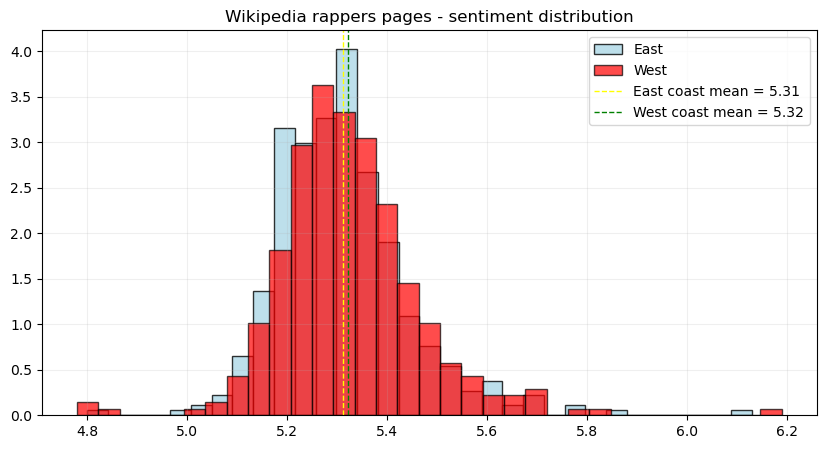

In [68]:
plt.figure(figsize = (10,5))

plt.hist(east_coast_sent, bins='auto', alpha=0.8, color='lightblue', edgecolor='black', label = 'East', density = True)

# bins = np.arange(min(west_coast_sent), max(west_coast_sent) + 0.05, 0.05)
plt.hist(west_coast_sent, bins='auto', alpha=0.7, color='red', edgecolor='black', label = 'West', density = True)
plt.axvline(mean_east, color='yellow', linestyle='dashed', linewidth=1, label=f'East coast mean = {mean_east:.2f}')
plt.axvline(mean_west, color='green', linestyle='dashed', linewidth=1, label=f'West coast mean = {mean_west:.2f}')

plt.title("Wikipedia rappers pages - sentiment distribution")
plt.legend()
plt.grid(alpha = 0.2)
plt.show()

* Judgnig by the sentiment distributions and the mean values, it seems that the West Coast is happier than the East Coast.
* The probabilities corresponding to values smaller than the mean are higher for the East Coast, while the probabilities corresponding to the other one are higher for the West Coast.

> Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.

> Does the result make sense to you? Elaborate.

* Null hypothesis **H0**: "There is no difference in the mean sentiment between the two groups, and any observed difference is due to random chance."
* Alternative hypothesis **H1**: "The group of west-coast pages tends to have higher mean sentiment than a similarly sized group of randomly chosen pages."
* Confidence bound $\alpha = 0.05$

In [52]:
N_iter = 10000
all_rappers = list(sentiments.keys())
length = len(west_coast_sent)
c = 0
for i in range(N_iter):
    random_sample = random.sample(all_rappers, length)
    avg_sent = mean([sentiments[rapper] for rapper in random_sample])
    c = c + 1 if round(avg_sent, 4) - round(mean_west, 4) >= 1e-5 else c

print(r'Actual p-value: %.3f' % (c/N_iter))

Actual p-value: 0.127


* The null hypothesis can't be rejected, since $p > \alpha$. Hence we can't conclude if the west-coast is the happier; 
* This makes sense to us, because just looking at the histogram plots won't guarantee that the alternative hypothesis is true;
* Moreover, when looking at the 10 happiest and saddest pages, there is no tendency for the rappers to belong to just one coast.